In [1]:
# !pip install lightgbm --no-cache-dir
# !pip install xgboost --no-cache-dir

In [2]:
import pandas as pd

In [3]:
file_path = "nn_leq.csv"
df = pd.read_csv(file_path)

In [4]:
df.head()

,id,term,yn
0,2,(x+y^3)/3=6,1
1,3,(x+y^3)/3=6,1
2,4,xyz=6,1
3,5,(x+y^3)/3,1
4,6,xyz=6,1


In [5]:
df = df.drop(columns = ['id'])

In [6]:
print(df.isnull().sum())

term    186
yn        0
dtype: int64


In [7]:
df = df.dropna()

In [8]:
df.shape

(392213, 2)

In [9]:
df.head()

,term,yn
0,(x+y^3)/3=6,1
1,(x+y^3)/3=6,1
2,xyz=6,1
3,(x+y^3)/3,1
4,xyz=6,1


In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features = 50000)

X = vectorizer.fit_transform(df['term'])

y = df['yn']

print(f"Shape of TF-IDF Matrx: {X.shape}")

Shape of TF-IDF Matrx: (392213, 50000)


In [32]:
import joblib
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")  # Save the vectorizer
print("✅ TF-IDF Vectorizer saved successfully!")


✅ TF-IDF Vectorizer saved successfully!


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print(f"Training data: {X_train.shape}, Testing data: {X_test.shape}")

Training data: (313770, 50000), Testing data: (78443, 50000)


In [12]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter = 500)

model.fit(X_train, y_train)

print("Model training completed!")

Model training completed!


In [13]:
from sklearn.metrics import accuracy_score, classification_report

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

print(classification_report(y_test, y_pred))

Model Accuracy: 0.93
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     68741
           1       0.83      0.51      0.64      9702

    accuracy                           0.93     78443
   macro avg       0.88      0.75      0.80     78443
weighted avg       0.92      0.93      0.92     78443



In [14]:
new_equations = ["F = ma", "2 + 3 = 5", "P = IV", "E = mc^2"]

X_new = vectorizer.transform(new_equations)

predictions = model.predict(X_new)

for eq, pred in zip(new_equations, predictions):
    print(f"Equation: {eq} --> {'Literal Euation (1)' if pred == 1 else 'Not a Literal Equation (0)'}")

Equation: F = ma --> Literal Euation (1)
Equation: 2 + 3 = 5 --> Not a Literal Equation (0)
Equation: P = IV --> Literal Euation (1)
Equation: E = mc^2 --> Literal Euation (1)


In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model_rf = RandomForestClassifier(n_estimators = 30, random_state = 42, n_jobs = -1)

model_rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf:.2f}")

Random Forest Accuracy: 0.94


In [16]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score

model_lgb = lgb.LGBMClassifier(
    boosting_type = 'gbdt',
    n_estimators = 100,
    device = 'gpu'
)

model_lgb.fit(X_train, y_train)

y_pred_lgb = model_lgb.predict(X_test)

accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
print(f"LightGBM (GPU) Accuracy: {accuracy_lgb:.2f}")

[LightGBM] [Info] Number of positive: 38493, number of negative: 275277
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 31011
[LightGBM] [Info] Number of data points in the train set: 313770, number of used features: 3590
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 4060 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.122679 -> initscore=-1.967301
[LightGBM] [Info] Start training from score -1.967301
LightGBM (GPU) Accuracy: 0.91


In [17]:
from xgboost import XGBClassifier

model_xgb = XGBClassifier(
    tree_method = 'gpu_hist',
    predictor = 'gpu_predictor',
    use_label_encoder = False,
    eval_metric = 'logloss',
    n_estimators = 100
)

model_xgb.fit(X_train, y_train)

y_pred_xgb = model_xgb.predict(X_test)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost (GPU) Accuracy: {accuracy_xgb: .2f}")

C:\Users\mailv\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:11:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\mailv\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:11:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost (GPU) Accuracy:  0.88


C:\Users\mailv\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:11:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
C:\Users\mailv\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:11:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster b

In [18]:
from sklearn.ensemble import ExtraTreesClassifier

model_et = ExtraTreesClassifier(
    n_estimators = 50,
    n_jobs = -1,
    random_state = 42
)

model_et.fit(X_train, y_train)

y_pred_et = model_et.predict(X_test)

accuracy_et = accuracy_score(y_test, y_pred_et)
print(f"Extra trees accuracy: {accuracy_et: .2f}")

Extra trees accuracy:  0.94


In [19]:
from sklearn.naive_bayes import MultinomialNB

model_nb = MultinomialNB()

model_nb.fit(X_train, y_train)

y_pred_nb = model_nb.predict(X_test)

accuracy_nb = accuracy_score(y_test, y_pred_nb)
print(f"Naive Bayes Accuracy: {accuracy_nb: .2f}")

Naive Bayes Accuracy:  0.92


In [20]:
from sklearn.svm import SVC

model_svm = SVC(kernel = 'linear')

model_svm.fit(X_train, y_train)

y_pred_svm = model_svm.predict(X_test)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f"SVM accuracy: {accuracy_svm: .2f}")

SVM accuracy:  0.93


In [21]:
from sklearn.metrics import accuracy_score, classification_report

# Dictionary to store results
model_results = {}

# Define models
models = {
    "Logistic Regression": model,
    "Random Forest": model_rf,
    "LightGBM": model_lgb,
    "XGBoost": model_xgb,
    "Extra Trees": model_et,
    "Naive Bayes": model_nb,
    "SVM": model_svm
}

# Evaluate each model
for name, mdl in models.items():
    y_pred = mdl.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)

    # Extract Precision, Recall, F1-Score for Class 1 (Literal Equations)
    if "1" in report:  # Ensure the class label "1" exists in report
        precision = report["1"]["precision"]
        recall = report["1"]["recall"]
        f1 = report["1"]["f1-score"]
    else:  # Handle cases where class "1" is missing
        precision, recall, f1 = 0, 0, 0  

    # Store extracted metrics
    model_results[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "Classification Report": report
    }

# Convert results to DataFrame
import pandas as pd
results_df = pd.DataFrame(model_results).T

# Display results
from IPython.display import display
print("Model Performance Comparison:")
display(results_df[["Accuracy", "Precision", "Recall", "F1-Score"]])  # Show main metrics

# Print classification reports
for name, result in model_results.items():
    print(f"\n{name} Performance:")
    print(f"Accuracy: {result['Accuracy']:.2f}")
    print(f"Precision: {result['Precision']:.2f}")
    print(f"Recall: {result['Recall']:.2f}")
    print(f"F1-Score: {result['F1-Score']:.2f}")
    print("Classification Report:")
    print(pd.DataFrame(result["Classification Report"]))


Model Performance Comparison:


,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.927119,0.833473,0.513296,0.635326
Random Forest,0.941856,0.830271,0.666048,0.739148
LightGBM,0.911796,0.875776,0.334261,0.483849
XGBoost,0.878842,0.834459,0.025459,0.04941
Extra Trees,0.941728,0.837344,0.65636,0.735887
Naive Bayes,0.923805,0.811403,0.500206,0.618887
SVM,0.932639,0.819682,0.583797,0.681917



Logistic Regression Performance:
Accuracy: 0.93
Precision: 0.83
Recall: 0.51
F1-Score: 0.64
Classification Report:
                      0            1  accuracy     macro avg  weighted avg
precision      0.934840     0.833473  0.927119      0.884157      0.922303
recall         0.985525     0.513296  0.927119      0.749411      0.927119
f1-score       0.959514     0.635326  0.927119      0.797420      0.919418
support    68741.000000  9702.000000  0.927119  78443.000000  78443.000000

Random Forest Performance:
Accuracy: 0.94
Precision: 0.83
Recall: 0.67
F1-Score: 0.74
Classification Report:
                      0            1  accuracy     macro avg  weighted avg
precision      0.954147     0.830271  0.941856      0.892209      0.938825
recall         0.980783     0.666048  0.941856      0.823416      0.941856
f1-score       0.967281     0.739148  0.941856      0.853215      0.939065
support    68741.000000  9702.000000  0.941856  78443.000000  78443.000000

LightGBM Performance:
A

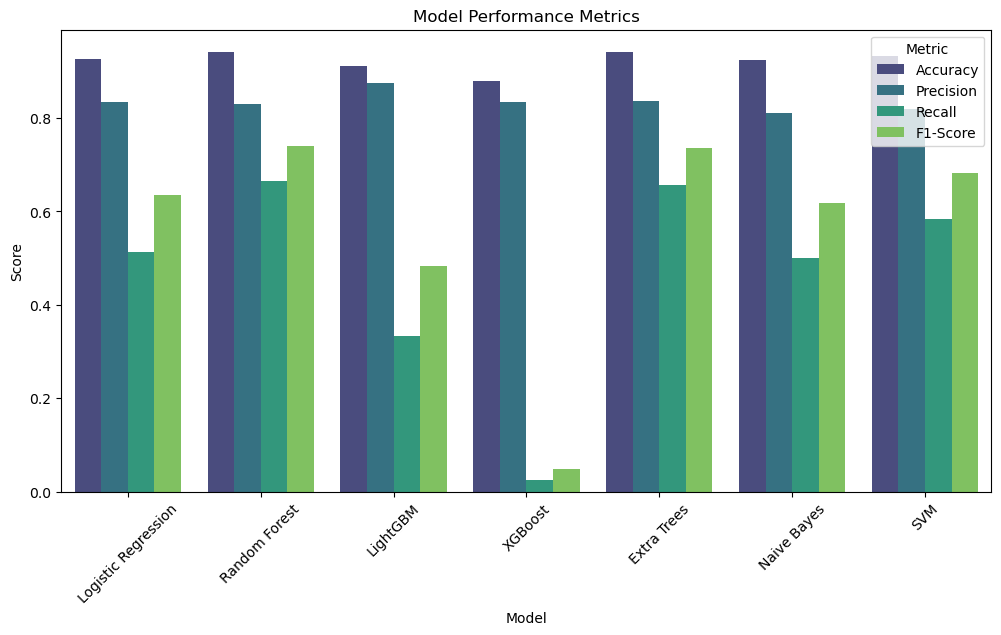

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Ensure model_results contains classification reports properly
results_cleaned = {}

for name, data in model_results.items():
    accuracy = data["Accuracy"]
    
    # Extract Precision, Recall, and F1-score for the positive class (1)
    classification_report_dict = data["Classification Report"]
    
    if "1" in classification_report_dict:  # Ensure key exists
        precision = classification_report_dict["1"]["precision"]
        recall = classification_report_dict["1"]["recall"]
        f1_score = classification_report_dict["1"]["f1-score"]
    else:  # Handle missing values
        precision, recall, f1_score = 0, 0, 0  

    results_cleaned[name] = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1_score
    }

# Convert cleaned dictionary to DataFrame
results_df = pd.DataFrame(results_cleaned).T

# Reset index to make 'Model' a column instead of row index
results_df = results_df.reset_index().rename(columns={"index": "Model"})

# Convert to long format for seaborn compatibility
results_long = results_df.melt(id_vars=["Model"], var_name="Metric", value_name="Score")

# Ensure values are numeric
results_long["Score"] = pd.to_numeric(results_long["Score"])

# Plot Model Performance
plt.figure(figsize=(12, 6))
sns.barplot(x="Model", y="Score", hue="Metric", data=results_long, palette="viridis")

# Improve readability
plt.title("Model Performance Metrics")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(title="Metric")

# Show plot
plt.show()


In [28]:
import joblib

# Select best model using F1-Score
best_model_name = max(model_results, key=lambda x: model_results[x]["F1-Score"])
best_model = models[best_model_name]

# Save the best model
model_filename = f"{best_model_name.replace(' ', '_').lower()}_best_model.pkl"
joblib.dump(best_model, model_filename)

print(f"\n🏆 Best Model: {best_model_name} saved as {model_filename}")
print(f"Accuracy: {model_results[best_model_name]['Accuracy']:.2f}")
print(f"Precision: {model_results[best_model_name]['Precision']:.2f}")
print(f"Recall: {model_results[best_model_name]['Recall']:.2f}")
print(f"F1-Score: {model_results[best_model_name]['F1-Score']:.2f}")



🏆 Best Model: Random Forest saved as random_forest_best_model.pkl
Accuracy: 0.94
Precision: 0.83
Recall: 0.67
F1-Score: 0.74


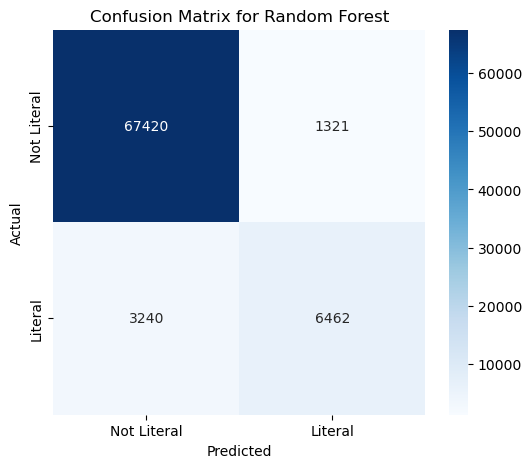

In [31]:
from sklearn.metrics import confusion_matrix

# Identify the best model based on accuracy
best_model_name = max(model_results, key=lambda x: model_results[x]["Accuracy"])
best_model = models[best_model_name]

# Predictions for the best model
best_y_pred = best_model.predict(X_test)

# Compute Confusion Matrix
cm = confusion_matrix(y_test, best_y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Literal", "Literal"], yticklabels=["Not Literal", "Literal"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix for {best_model_name}")
plt.show()

In [25]:
# from sklearn.model_selection import GridSearchCV

# # Example for Random Forest (adjust based on best model)
# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# grid_search = GridSearchCV(best_model, param_grid, cv=5, scoring='f1', n_jobs=-1)
# grid_search.fit(X_train, y_train)

# print(f"Best Parameters: {grid_search.best_params_}")
# best_model = grid_search.best_estimator_
